In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mnist_train=dset.MNIST("", train=True,transform=transforms.ToTensor(),target_transform=None,download=True)
mnist_test=dset.MNIST("",train=False,transform=transforms.ToTensor(),target_transform=None,download=True)

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태: torch.Size([1, 28, 28])
label: 5


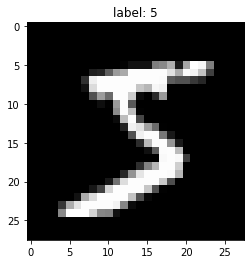

In [4]:
print("mnist_train 길이:",len(mnist_train))
print("mnist_test 길이:",len(mnist_test))

#데이터 하나 형태
image, label = mnist_train.__getitem__(0)
print("image data 형태:",image.size())
print("label:",label)

#그리기
img=image.numpy() #image 타입을 numpy로 변환 (1,28,28)
plt.title("label: %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

5
torch.Size([1, 28, 28])
5
0
4


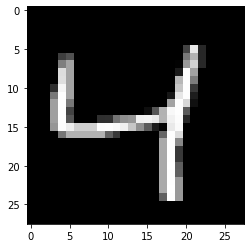

In [13]:
print(mnist_train[0][1]) #label
print(mnist_train[0][0].size()) #image

for i in range(3):
    img=mnist_train[i][0].numpy()
    print(mnist_train[i][1])
    plt.imshow(img[0],cmap='gray')
    plt.show

torch.Size([1, 1, 28, 28])
5
torch.Size([1, 3, 28, 28])


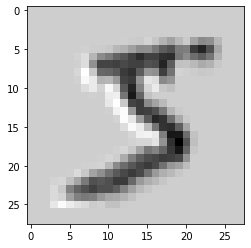

In [16]:
# mnist의 첫 번째 이미지, 라벨 가져오기
image, label = mnist_train[0]
#view: tensor의 사이즈 조절, -1: 해당 차원 차원 확장시켜라
# [1,28,28] -> [1,1,28,28]
image= image.view(-1,image.size()[0], image.size()[1],image.size()[2])
print(image.size())

print(label)

# convolutional filter 정의
conv_layer=nn.Conv2d(in_channels=1,out_channels=3,kernel_size=3,padding=1)
# image에 filter 적용
output=conv_layer(Variable(image))
print(output.size())

for i in range(3):
    plt.imshow(output[0,i,:,:].data.numpy(), cmap='gray')
    plt.show

In [17]:
import numpy as np
import torch.optim as optim

batch_size=16
learning_rate = 0.0002
num_epoch = 10

In [18]:
train_loader = torch.utils.data.DataLoader(list(mnist_train)[:batch_size*100],batch_size=batch_size,
                                          shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader((mnist_test), batch_size=batch_size, shuffle=False,
                                         num_workers=2,drop_last=True)

In [19]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(1,16,5,padding=2),
            nn.ReLU(),
        
            nn.Conv2d(16,32,5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(32,64,5,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*7*7,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(batch_size, -1)
        out = self.fc_layer(out)
        return out

model = CNN()

In [20]:
for parameter in model.parameters():
    #print(parameter)
    print(parameter.shape)

torch.Size([16, 1, 5, 5])
torch.Size([16])
torch.Size([32, 16, 5, 5])
torch.Size([32])
torch.Size([64, 32, 5, 5])
torch.Size([64])
torch.Size([100, 3136])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [21]:
loss_func=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [22]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        x=Variable(image)
        y_=Variable(label)
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss = loss_func(output, y_)
        loss.backward()
        optimizer.step()
        
        if j%50==0:
            print(loss, j ,i)

tensor(2.3116, grad_fn=<NllLossBackward>) 0 0
tensor(1.7911, grad_fn=<NllLossBackward>) 50 0
tensor(1.2162, grad_fn=<NllLossBackward>) 0 1
tensor(0.4841, grad_fn=<NllLossBackward>) 50 1
tensor(0.4378, grad_fn=<NllLossBackward>) 0 2
tensor(0.5400, grad_fn=<NllLossBackward>) 50 2
tensor(0.4320, grad_fn=<NllLossBackward>) 0 3
tensor(0.2771, grad_fn=<NllLossBackward>) 50 3
tensor(0.4332, grad_fn=<NllLossBackward>) 0 4
tensor(0.0359, grad_fn=<NllLossBackward>) 50 4
tensor(0.0647, grad_fn=<NllLossBackward>) 0 5
tensor(0.3467, grad_fn=<NllLossBackward>) 50 5
tensor(0.0922, grad_fn=<NllLossBackward>) 0 6
tensor(0.0110, grad_fn=<NllLossBackward>) 50 6
tensor(0.0209, grad_fn=<NllLossBackward>) 0 7
tensor(0.0638, grad_fn=<NllLossBackward>) 50 7
tensor(0.0052, grad_fn=<NllLossBackward>) 0 8
tensor(0.1204, grad_fn=<NllLossBackward>) 50 8
tensor(0.0147, grad_fn=<NllLossBackward>) 0 9
tensor(0.0769, grad_fn=<NllLossBackward>) 50 9


In [23]:
#모델 저장시키기
torch.save(model, 'nets/mycnn_model_%d.pkl'%(num_epoch))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [24]:
try:
    model=torch.load('nets/mycnn_model_10.pkl')
    print("model restored")
except:
    print("model not restored")

model restored


In [25]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        img = Variable(imgs)
        label = Variable(labels)
        
        output = imodel.forward(img)
        _, output_index = torch.max(output,1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [26]:
ComputeAccr(test_loader,model)

Accuracy of Test Data: 95.02999877929688
